# CNN-lytical Assignment-3
<center>
<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS7fZ0PJ4leQi4qtXR5Egv5YILqQqvzVSNtFg&usqp=CAU">
</center>

*  In this assignment, we will use CNNs in [PyTorch](https://pytorch.org/docs/stable/index.html) for image classification.

* We have been using MNIST by flattening 28$\times$28 images to 784-sized vectors.

* This time, we will classify images from the CIFAR-10 dataset - dimension is 32$\times$32.

* Much of this notebook remains the same as for Assignment 2, just minor changes would be needed and this assignment won't take long.

**Feel free to redefine any function signatures below, just make sure the final cell remains the same.**

## Import libraries here
PyTorch, NumPy, Matplotlib, ...
Even when equipped with PyTorch, NumPy and Matplotlib make your work easier for visualization etc.

Note the following method to **initialize the seed** for reproducibility of results, both for NumPy & PyTorch (CPU/CUDA).

In [179]:
import torch
import os
import torch.nn as nn 
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np
import pickle 
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
import torch.backends.cudnn as cudnn

def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(42)


## Load *Dataset*
Use the [pickle file](https://drive.google.com/file/d/1_IHICOfAsT7x63VBBuN1WMh4bDqtUThp/view?usp=sharing) shared for this assignment here.

In [180]:
#needs change
# mount Google Drive to access the dataset
from google.colab import drive
drive.mount('/content/gdrive')

# load the data set
with open('/content/gdrive/My Drive/CNN/asgn_3/train_cifar.pkl', 'rb') as f:
    data = pickle.load(f)

X = data['X']
y = data['y']

# normalisation
# std_vec=np.std(x_prev,axis=0)
# std_vec[np.where(std_vec==0)]=1e-22
# X=(x_prev-np.mean(x_prev,axis=0))/std_vec

# Split into X_train, y_train, X_test, y_test
# you can use stratified splitting from sklearn library
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.25)


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


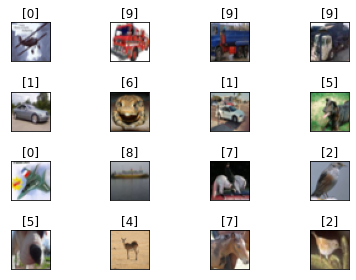

In [181]:
# display a 4x4 grid, 
# choose 16 images randomly, display the images as well as corresponding labels
# print(X_train.shape)
# print(y_train.shape)
random_indices = np.random.choice(X.shape[0]-1, size=16, replace=False)
random_images = X[random_indices, :]
random_images_labels = y[random_indices, :]

# Create plt plot:
fig = plt.figure()

for i in range(16):
  plt.subplot(4,4,i+1)
  plt.imshow(np.reshape(random_images[i],(32,32,3)))
  plt.title("{}".format(random_images_labels[i]))
  plt.xticks([])
  plt.yticks([])

fig.tight_layout()

## Creating a Dataset Class
In PyTorch, there is existing implementation of batch-splitting. You don't need to do it manually over here. Instead, just define a Dataset class and a Dataloader wrapping it.

A dataset class must have 3 functions - ```__init__```, ```__len__```, ```__getitem__```. Their names are pretty self-explanatory. You can read more about this [here](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).

You will have to perform normalization, augmentation on the dataset here itself, have a look at [PyTorch Transforms](https://pytorch.org/vision/stable/transforms.html).

**Note -** While initializing the dataset class object, make sure you only pass the numpy arrays for images and labels. So the ```__init__``` function should look like
```
    def __init__(self, X, y):
```

In [182]:
# define your dataset class
class ImageDataset(Dataset):
    def __init__(self, X, y):
        self.img_labels = y
        self.imgs = X
        T0 = transforms.ToPILImage()
        # T1 = transforms.RandomCrop(32, padding=4)
        T2 = transforms.RandomHorizontalFlip()
        T3 = transforms.ToTensor()
        # using these values for normalising different channels since these are globally available value for CIFAR 10 dataset
        nr = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

        # Transforms object for trainset with augmentation
        transform_with_aug = transforms.Compose([T0, T2, T3, nr])
        
        self.transform = transform_with_aug
        
    def __len__(self):
        return len(self.img_labels)
        
    def __getitem__(self, idx):
        image = self.imgs[idx]
        label = self.img_labels[idx]
        if self.transform:
          image = self.transform(image)
        return image, label



## ```nn.Module``` for your model
In this segment, define a class for your model, it has to inherit from the ```nn.Module``` class. You must define two functions here - ```__init__``` and ```forward```, again pretty self-explanatory. Helper functions can also be implemented, your choice!

Look into the following ```torch``` layers beyond those you used in the second assignment and combine them to form your network, you can find more [here](https://pytorch.org/docs/stable/nn.html) -
- [```nn.Conv2d```](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)
- [```nn.BatchNorm2d```](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html)


In [183]:
#needs change
import torch.nn as nn 

# define a child class of nn.Module for your model
# specify the architecture here itself
class NeuralNet(nn.Module):

    def __init__(self,num_classes):
         super(NeuralNet, self).__init__()
         self.l1=   nn.Conv2d(3, 32, kernel_size=3, padding=1)#32 filters dimension remains 32 since stride is 1 by default
         self.l2=   nn.ReLU()
         self.l3=   nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)#64 filters dimension remains 32 since stride is 1 by default
         self.l4=   nn.ReLU()
         self.l5=   nn.MaxPool2d(2, 2) # output: 64 x 8 x 8
         self.l6=   nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
         self.l7=   nn.ReLU()
         self.l8=   nn.BatchNorm2d(128)
         self.l9=   nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
         self.l10=   nn.ReLU()
         self.l11=   nn.MaxPool2d(2, 2) # output: 128 x 8 x 8
         self.l19=   nn.Flatten() 
         self.l20=   nn.Linear(128*8*8, 1024)
         self.l21=   nn.ReLU()
         self.l22=   nn.Linear(1024, 256)
         self.l23=   nn.ReLU()
         self.l24=   nn.Linear(256, num_classes)
                
    def forward(self, x):
         out = self.l1(x)
         out = self.l2(out)
         out = self.l3(out)
         out = self.l4(out)
         out = self.l5(out)
         out = self.l6(out)
         out = self.l7(out)
         out = self.l8(out)
         out = self.l9(out)
         out = self.l10(out)
         out = self.l11(out)
         out = self.l19(out)
         out = self.l20(out)
         out = self.l21(out)
         out = self.l22(out)
         out = self.l23(out)
         out = self.l24(out)
         
         # no softmax at the end since already included in cross entropy loss function
         return out



## Training loop
You can write a training loop but usually writing it within a function helps so that you can train in multiple passes with just one function call if you still don't see convergence of the loss. ```display_step``` is for you to display results on the validation set (which you must not have trained upon).

You will need to use ```zero_grad()```, ```backward()``` and multiple such functions here. Look for them in the tutorials given.

In [184]:
#needs change
def train(model, optimizer, criterion, train_loader,test_loader, display_step=None):
    for i, (images, labels) in enumerate(train_loader):   
         
         # Forward pass
         images, labels = images.cuda(), labels.cuda()
         outputs = model(images.float())
         labels=torch.flatten(labels)
         loss = criterion(outputs, labels)
         
         # Backward and optimize
         optimizer.zero_grad()
         loss.backward()
         optimizer.step()

    if (display_step==1):
      print("Train Loss is: ",loss.item())
      test_features, test_labels = next(iter(test_loader))
      test_features = test_features.cuda()
      predicted=predict(model,test_features)
      val=accuracy(predicted,(test_labels.cpu().numpy()).flatten())
      print("Test Accuracy is: ",val)


## Initialize weights
Write a small function to initialize weights for your model. You don't need to do it individually for each layer, there are ways to do it in a simple ```for``` loop.

In [185]:
#needs change
def init_weights(model_instance):
    if isinstance(model_instance, nn.Linear) or isinstance(model_instance, nn.Conv2d):
        torch.nn.init.xavier_uniform_(model_instance.weight)
        model_instance.bias.data.fill_(0.001)


## Prediction & Accuracy
Prediction function should predict outputs using your trained model for a given **NumPy array** ```X_test``` and the output should be another **NumPy array**.

The accuracy function would be the same as before.

In [186]:
def predict(model, X_test):
    outputs=model((torch.tensor(X_test)).float())
    _, predicted = torch.max(outputs.data, 1)
    return predicted.cpu().numpy()

In [187]:
def accuracy(pred, labels):
    frac_correct = np.mean(pred == labels)
    return 100*frac_correct

## Actually training your model
- Create a model, initialize it. Define optimizer for the model as well as loss criterion (you can actually set the seed here again, just in case you did some ```rand``` calls above for testing your functions).
- Define an instance of the dataset class, wrap it in a dataloader.
- Call the train function and train your model!


In [188]:
#needs change 

num_classes = 10
num_epochs = 51
batch_size = 128
learning_rate = 0.05 
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

train_dataset = ImageDataset(X_train,y_train)
test_dataset = ImageDataset(X_test,y_test)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

network=NeuralNet(10)
# move tensors to GPU if CUDA is available
if train_on_gpu:
  network = network.cuda()
  network = torch.nn.DataParallel(network)
  cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()

#optimizer=torch.optim.Adam(network.parameters(), lr=learning_rate)
optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate)

#initiate
network.apply(init_weights)

for epoch in range(num_epochs):
  print(epoch)
  if (epoch%5==0):
    train(network, optimizer, criterion, train_dataloader, test_dataloader, 1)
  else:
    train(network, optimizer, criterion, train_dataloader, test_dataloader, 0)    

final_model=network

CUDA is available!  Training on GPU ...
0
Train Loss is:  1.2516804933547974
Test Accuracy is:  55.46875
1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


2
3
4
5
Train Loss is:  0.7856733202934265
Test Accuracy is:  70.3125
6
7
8
9
10
Train Loss is:  0.29955586791038513
Test Accuracy is:  75.0
11
12
13
14
15
Train Loss is:  0.09920327365398407
Test Accuracy is:  75.78125
16
17
18
19
20
Train Loss is:  0.018385959789156914
Test Accuracy is:  80.46875
21
22
23
24
25
Train Loss is:  0.0007547711138613522
Test Accuracy is:  83.59375
26
27
28
29
30
Train Loss is:  0.0006931814714334905
Test Accuracy is:  85.15625
31
32
33
34
35
Train Loss is:  0.0002669261593837291
Test Accuracy is:  81.25
36
37
38
39
40
Train Loss is:  0.00019428881932981312
Test Accuracy is:  84.375
41
42
43
44
45
Train Loss is:  0.00029687368078157306
Test Accuracy is:  79.6875
46
47
48
49
50
Train Loss is:  0.0003067132201977074
Test Accuracy is:  85.9375


## Run your model for the validation dataset
Use your trained model to get predictions for the validation dataset you split earlier.

In [189]:
# load the model, use predict function
with torch.no_grad():
    predicted_arr=np.zeros(64)
    nums=0
    sum_accuracy=0
    
    for i, (images, labels) in enumerate(test_dataloader):
      images=images.cuda()   
      predicted=predict(final_model,images)
      nums+=1
      val=accuracy(predicted,(labels.cpu().numpy()).flatten())
      print(val)
      sum_accuracy+=val
    
    print(sum_accuracy/nums)

    # predicted_arr[i]=predicted 
    #  predicted=predict(final_model,X_test) 
    #  print(accuracy(predicted,y_test.flatten()))  

88.28125
86.71875
83.59375
80.46875


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


83.59375
83.59375
75.78125
84.375
83.59375
80.46875
86.71875
85.15625
81.25
85.15625
82.03125
74.21875
82.8125
83.59375
82.03125
82.8125
82.03125
85.15625
85.15625
79.6875
84.375
77.34375
83.59375
88.28125
80.46875
82.8125
85.15625
84.375
74.21875
81.25
81.25
85.15625
82.03125
87.5
76.5625
83.59375
83.59375
85.15625
85.9375
82.03125
81.25
81.25
84.375
79.6875
80.46875
85.9375
80.46875
79.6875
79.6875
81.25
77.34375
82.03125
78.90625
75.0
83.59375
80.46875
83.59375
75.78125
85.15625
78.90625
85.15625
86.71875
77.34375
82.03125
84.375
81.25
84.375
89.0625
83.59375
82.03125
79.6875
79.6875
76.5625
85.9375
78.90625
79.6875
85.15625
79.6875
79.6875
84.375
85.9375
78.90625
82.8125
85.15625
79.6875
77.34375
82.8125
82.03125
84.375
82.03125
78.90625
85.15625
79.6875
77.38095238095238
82.09540512633625


## Submission
To submit your solution, you will need to make a file with name ```model.py``` containing imports necessary to write the model class and the model class itself. It shouldn't do anything else when run. Also create a file ```dataset.py``` with the dataset class and all necessary imports. Other than this, save the trained model in a file named ```ass_2.pt```. When you are done with the assignment, commit the updated notebook, the ```model.py```, ```dataset.py``` class files and the ```ass_2.pt``` model-weights file to the repository.

In [190]:
from google.colab import files
torch.save(final_model, 'ass_3.pt')
files.download('ass_3.pt') # download the file from the Colab session for submission

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Check if it got saved right!

In [192]:
# load the model, use predict function
loaded_model=torch.load('/content/gdrive/My Drive/CNN/asgn_3/ass_3.pt')

with torch.no_grad():
    predicted_arr=np.zeros(64)
    nums=0
    sum_accuracy=0
    
    for i, (images, labels) in enumerate(test_dataloader):
      images=images.cuda()   
      predicted=predict(final_model,images)
      nums+=1
      val=accuracy(predicted,(labels.cpu().numpy()).flatten())
      #print(val)
      sum_accuracy+=val
    
    print(sum_accuracy/nums)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


81.9837979834791
